<a href="https://colab.research.google.com/github/santolina/Convolutional-Neural-Networks-in-TensorFlow/blob/master/NLP_Course_Week_3_Exercise_Question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=160000 #Your dataset size here. Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 to see the best effects
test_portion=.1

corpus = []


In [32]:

# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv
# I then hosted it on my site to make it easier to use in this notebook

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

num_sentences = 0

with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      # Your Code here. Create list items where the first item is the text, found in row[5], and the second is the label. Note that the label is a '0' or a '4' in the text. When it's the former, make
      # your label to be 0, otherwise 1. Keep a count of the number of sentences in num_sentences
        list_item=[]
        label = int(row[0].replace("4", "1"))          

        list_item.append([row[5], label])

        # YOUR CODE HERE
        num_sentences = num_sentences + 1
        corpus.append(list_item)




--2019-11-18 12:58:29--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 2a00:1450:4013:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M   189MB/s    in 1.2s    

2019-11-18 12:58:30 (189 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [33]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
[["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]]


In [0]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentence, label = corpus[x][0]
    sentences.append(sentence)
    labels.append(label)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences) # YOUR CODE HERE)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type) # YOUR CODE HERE)

split = int(test_portion * training_size)

test_sequences = padded[split:] # YOUR CODE HERE]
training_sequences = padded[:split] # YOUR CODE HERE]
test_labels = labels[split:] # YOUR CODE HERE]
training_labels = labels[:split] # YOUR CODE HERE]

In [35]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138858
# 1

138536
1


In [36]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2019-11-18 12:59:00--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 2a00:1450:4013:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   159MB/s    in 2.1s    

2019-11-18 12:59:02 (159 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [37]:
print(len(embeddings_matrix))
# Expected Output
# 138859

138537


In [40]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Conv1D(64, 5, activation="relu"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation="relu"),
    tf.keras.layers.Dense(1, activation='sigmoid')
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

num_epochs = 50
history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels), verbose=1)

print("Training Complete")


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 16, 100)           13853700  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 12, 64)            32064     
_________________________________________________________________
global_average_pooling1d_3 ( (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7         
Total params: 13,886,161
Trainable params: 32,461
Non-trainable params: 13,853,700
_________________________________________________________________
Train on 16000 samples, validate on 144000 samples
Epoch 1/50
16000/16000 [============================

<Figure size 432x288 with 0 Axes>

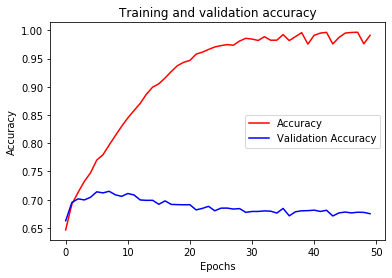

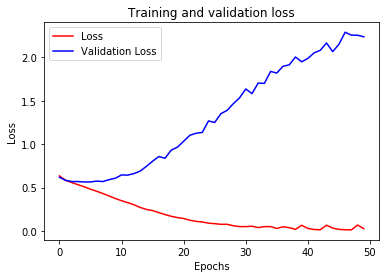

<Figure size 432x288 with 0 Axes>

In [41]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

In [42]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Conv1D(64, 5, activation="relu"),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(6, activation="relu"),
    tf.keras.layers.Dense(1, activation='sigmoid')
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
])
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model2.summary()

num_epochs = 50
history2 = model2.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels), verbose=1)

print("Training Complete")


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 16, 100)           13853700  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 12, 64)            32064     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 774       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 7         
Total params: 13,952,593
Trainable params: 98,893
Non-trainable params: 13,853,700
_________________________________________________________________
Train on 16000 samples, validate on 144000 samples
Epoch 1/50
16000/16000 [============================

<Figure size 432x288 with 0 Axes>

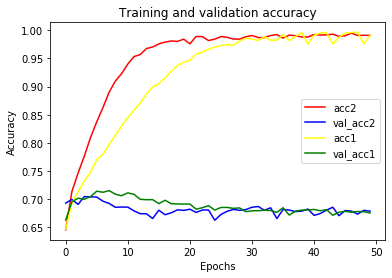

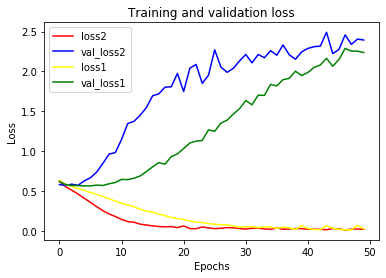

<Figure size 432x288 with 0 Axes>

In [45]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc2=history2.history['acc']
val_acc2=history2.history['val_acc']
loss2=history2.history['loss']
val_loss2=history2.history['val_loss']

epochs=range(len(acc2)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc2, 'r', label='acc2')
plt.plot(epochs, val_acc2, 'b', label='val_acc2')
plt.plot(epochs, acc, 'yellow', label='acc1')
plt.plot(epochs, val_acc, 'green', label='val_acc1')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
#plt.legend(["Accuracy", "Validation Accuracy"])
plt.legend(loc='best')

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss2, 'r', label='loss2')
plt.plot(epochs, val_loss2, 'b', label='val_loss2')
plt.plot(epochs, loss, 'yellow', label='loss1')
plt.plot(epochs, val_loss, 'green', label='val_loss1')

plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
#plt.legend(["Loss", "Validation Loss"])
plt.legend(loc='best')

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!